## Welcome to the first-ever (and hopefully last-ever) remote ADA final exam (Fall 2020)

In this exam, you will analyze data from Wikipedia and from the [Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) game, which you have already encountered in lecture 12 on [“Handling networks”](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_92). The rules of the Wikispeedia game are simple:
1. Players are given two Wikipedia articles: a *source* and a *target*.
2. Starting from the source article, the goal is to reach the target, exclusively by following links in the articles encountered along the path.

### The data

The Wikispeedia data comprises ~76K games by human players, thereby capturing human navigation behavior on a very small subset of English Wikipedia comprising ~4.5K articles with a total of ~120K links between them.

The dataset is available in the `data` directory pushed to the same GitHub repo as the exam. Inside the data directory, you will find four files:

####  1. `article_df_task-A.tsv.gz`: A tab-separated file with the following information about Wikipedia articles
- *name*: The name of the Wikipedia article
- *topic*: The top-level topic label for the article (each article is assigned exactly one topic label)
- *content*: The cleaned text of the article (having removed punctuations, stopwords, numbers, and letter casing). It is stored as a space-separated string.

#### 2. `links_task-B.tsv.gz`: A tab-separated file containing Wikipedia links
- *linkSource*: The name of the source Wikipedia article from which the link originates
- *linkTarget*: The name of the target Wikipedia article to which the link points

#### 3.  `paths_df_task-B.tsv.gz`: A tab-separated file with the following information about the played games
- *hashed_ip_address*: Anonymized IP address of the player
- *source*: The name of the Wikipedia article from where the game started
- *target*: The name of the target article that the player was supposed to reach 
- *finished*: Whether the game was successfully finished (whether the player reached the target article)
- *human_path_length*: The number of clicks made by the player, before they either reached the target (in *finished* games) or gave up (in *unfinished* games)
- *shortest_path_length*: The minimum number of clicks required to reach the target article from the source article. Disconnected source-target article pairs have a shortest_path_length of *-1*.
- *duration_in_sec*: The duration of the game in seconds

#### 4.  `paths_df_task-C.tsv.gz`: In continuation to the task-B paths dataframe, this tab-separated file has the following additional information
- *in_degree_target*: In-degree of the target article, that is the number of incoming links that lead to the target article

*Note: In all the aforementioned files, the first line contains the header information. Additionally, article names are URL-encoded. For example, 'Antonín_Dvořák' is stored as 'Anton%C3%ADn_Dvo%C5%99%C3%A1k'. If needed, you can decode the article names using this code: `from urllib.parse import unquote; unquote('article-name')`.*

In [2]:
''' Some minimalistic imports '''
import pandas as pd
import random
import gzip
import operator
import time
from urllib.parse import unquote

import math
import numpy as np
import scipy.stats as stats
import sklearn

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Task A. Can we predict article topic using textual content? (30 points)

*Note-1: For the entire Task A, we will use logistic regression for its scalability and simplicity. Specifically, we will use [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) available in `sklearn` with 'log' loss and '5' epochs for training a logistic regression classifier.*

*Note-2: In all the cases where random number generation is required (train-test split, fitting the model, etc.), make sure to use 42 as the random seed.*

### A1. Load the text data and analyze the topic distribution (2 points)
1. Load `data/article_df_task-A.tsv.gz` as a pandas dataframe.   
   *Note: we have already cleaned the text for you!*
2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

In [4]:
data_folder = 'data/'
article_df = pd.read_csv(data_folder+'article_df_task-A.tsv.gz', sep='\t', compression='gzip')

In [3]:
article_df

,name,topic,content
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,copyright aedan mac gabrain schools wikipedia ...
1,%C3%85land,Geography,copyright aland schools wikipedia selection re...
2,%C3%89douard_Manet,People,copyright edouard manet schools wikipedia sele...
3,%C3%89ire,Geography,copyright eire schools wikipedia selection rel...
4,%C3%93engus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...
...,...,...,...
4593,Zionism,People,copyright zionism schools wikipedia selection ...
4594,Zirconium,Science,copyright zirconium schools wikipedia selectio...
4595,Zoroaster,People,copyright zoroaster schools wikipedia selectio...
4596,Zuid-Gelders,Geography,copyright zuid gelders schools wikipedia selec...


In [4]:
print("Total number of topics:", len(article_df.topic.unique()))

Total number of topics: 14


Text(0, 0.5, 'Number of articles')

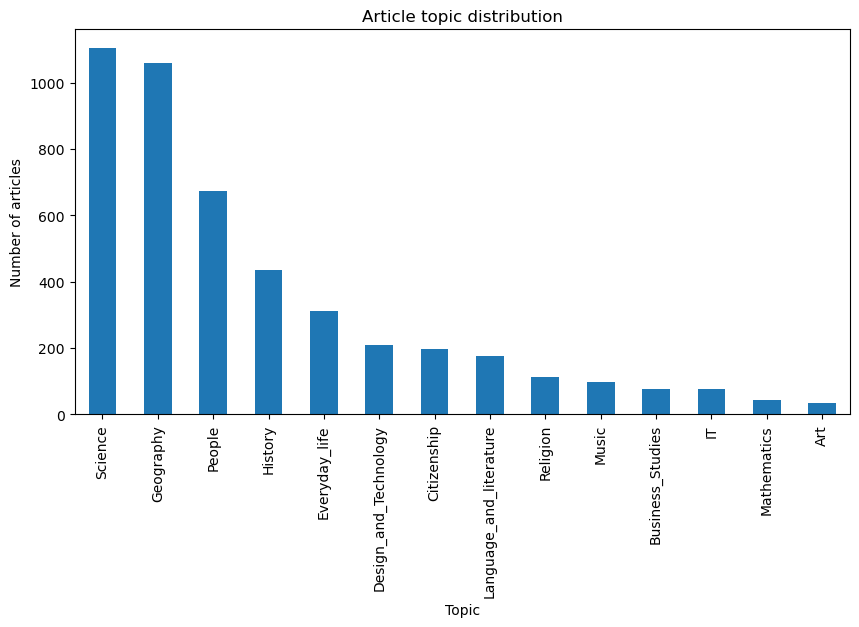

In [5]:
# Plot article topic distribution:
article_df.topic.value_counts().plot(kind='bar', figsize=(10, 5), title='Article topic distribution')
plt.xlabel('Topic')
plt.ylabel('Number of articles')

2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

There are 14 topics. The article topic distribution is skewed majorly towards the 'Science' topic followed by the 'Geography' topic, both containing above 1000 articles. Others contain nearly half and decrease down to less than 100.

### A2. Topic classification (multi-class): Articles from 5 most frequent topics (8 points)

#### A2.1 Prepping the data for ML (3 points)
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

#### A2.2 Train and evaluate a multi-class classifier (5 points)
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

#### A2.1 Prepping the data for ML (3 points)
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

In [6]:
# 1. Select articles corresponding to top-5 topics based on topic frequency:
article_df.value_counts('topic').sort_values(ascending=False).head(5)

topic
Science          1105
Geography        1058
People            673
History           434
Everyday_life     310
dtype: int64

In [7]:
# We select the top 5 topics based on the number of articles in each topic:
top_5_topics = article_df.value_counts('topic').sort_values(ascending=False).head(5).index
article_df_top_5 = article_df[article_df.topic.isin(top_5_topics)]

In [8]:
article_df_top_5

,name,topic,content
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,copyright aedan mac gabrain schools wikipedia ...
1,%C3%85land,Geography,copyright aland schools wikipedia selection re...
2,%C3%89douard_Manet,People,copyright edouard manet schools wikipedia sele...
3,%C3%89ire,Geography,copyright eire schools wikipedia selection rel...
4,%C3%93engus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...
...,...,...,...
4593,Zionism,People,copyright zionism schools wikipedia selection ...
4594,Zirconium,Science,copyright zirconium schools wikipedia selectio...
4595,Zoroaster,People,copyright zoroaster schools wikipedia selectio...
4596,Zuid-Gelders,Geography,copyright zuid gelders schools wikipedia selec...


In [9]:
# 2. Construct a TF-IDF representation of textual content:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() # does tokenization, stopword removal, and TF-IDF at once
X = vectorizer.fit_transform(article_df_top_5.content)
# x = vectorizer.fit_transform(article_df_top_5.content.to_numpy()).toarray()

In [10]:
# 3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. 
# Perform this encoding and add a new column of ordinal class labels in the current dataframe:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
article_df_top_5 = article_df_top_5.assign(topic_encoded = le.fit_transform(article_df_top_5.topic))
article_df_top_5

,name,topic,content,topic_encoded
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,copyright aedan mac gabrain schools wikipedia ...,3
1,%C3%85land,Geography,copyright aland schools wikipedia selection re...,1
2,%C3%89douard_Manet,People,copyright edouard manet schools wikipedia sele...,3
3,%C3%89ire,Geography,copyright eire schools wikipedia selection rel...,1
4,%C3%93engus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...,3
...,...,...,...,...
4593,Zionism,People,copyright zionism schools wikipedia selection ...,3
4594,Zirconium,Science,copyright zirconium schools wikipedia selectio...,4
4595,Zoroaster,People,copyright zoroaster schools wikipedia selectio...,3
4596,Zuid-Gelders,Geography,copyright zuid gelders schools wikipedia selec...,1


In [11]:
# 4. Create two numpy arrays: 
# X (TF-IDF representation of each article) and y (class-label of each article):
# Convert X and topic_encoded to numpy arrays:
X = X.toarray()
y = article_df_top_5.topic_encoded.values
print(X.shape, y.shape)

(3580, 195694) (3580,)



#### A2.2 Train and evaluate a multi-class classifier (5 points)
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

In [12]:
# 1. Split the dataset into training and test sets (70/30 split):
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We should ALWAYS do first the split and THEN the transformation:

(By using transform when dealing with the test set, I ensure that only words appearing in the train set are considered):

In [ ]:
#X_train = vectorizer.fit_transform(train_set.content)
#X_test = vectorizer.transform(test_set.content)

In [13]:
# 2. Train a classifier (e.g., logistic regression) with L2 regularization using SGDClassifier() method of sklearn: 
from sklearn.linear_model import SGDClassifier
clf_multiclass = SGDClassifier(loss='log', alpha=1e-4, random_state=42, max_iter=5, tol=None)
clf_multiclass.fit(X_train, y_train)
print("Testing accuracy:", clf_multiclass.score(X_test, y_test))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing accuracy: 0.8901303538175046


The testing accuracy is very high compared to a random baseline. In a 5-class classification a random model obtains an accuracy of 20% in expectation. Thus, obtaining an accuracy as high as 80% is a strong outcome.

### A3. Topic classification (binary): Articles from the most and least frequent topics (12 points)

#### A3.1 Train and evaluate a binary classifier (2 points)
1. Restrict the data to articles belonging to the most frequent or to the least frequent topic.
2. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).
3. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
4. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.
5. Report the classifier performance on the test data using accuracy as the metric.

In [19]:
# Restrict the data to articles belonging to the most frequent or to the least frequent topic: 
# 1. Select articles corresponding to the most frequent topic:
article_df_most_freq = article_df[article_df.topic == article_df.topic.value_counts().index[0]]
article_df_least_freq = article_df[article_df.topic == article_df.topic.value_counts().index[-1]]
article_df_mostandleast_freq = pd.concat([article_df_most_freq, article_df_least_freq])
article_df_mostandleast_freq = article_df_mostandleast_freq.assign(topic_encoded = le.fit_transform(article_df_mostandleast_freq.topic))

In [20]:
# Create 2 numpy arrays X and y:
X_binary = vectorizer.transform(article_df_mostandleast_freq.content).toarray()
y_binary = article_df_mostandleast_freq.topic_encoded.values

In [23]:
# Print number of unique values in y:
print("Number of unique values in y:", len(np.unique(y_binary)))

Number of unique values in y: 2


In [24]:
# Perform a train-test split with 60% as the training portion and random_state = 42:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.4, random_state=42)

In [25]:
# Train a logistic regression classifier with the L2 regularization using SGDClassifier() method of sklearn:
SGD_class = SGDClassifier(loss='log', alpha=1e-4, random_state=42, max_iter=5, tol=None)
SGD_class.fit(X_train_binary, y_train_binary)
print("Testing accuracy:", SGD_class.score(X_test_binary, y_test_binary))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing accuracy: 0.9802631578947368


#### A3.2 Assessing the evaluation metric (5 points)
1. **/Discuss:/** What is your take on the accuracy obtained in A3.1? Do you think accuracy is the correct evaluation metric for this task? If yes, justify! If not, why not, and what else can be used?
2. If you included additional evaluation metrics in A3.2.1, then perform an empirical analysis of the performance using these metrics.   
   **/Discuss:/** Additionally, discuss what you observe. Is it harder to predict the topic labels of certain articles? Why, or why not? Please elaborate!

1. Accuracy is a good metric when classes are not skewed and that errors share the same importance level (FP and FN) while here we took the most and least frequent article topics. Hence, the accuracy is biased because the number of articles in the most and least frequent topics is highly unbalanced. Hence, accuracy will be biased towards the class containing most of the data and here, overestimates the classifier's performance (0.98). In this case we can either use balanced accuracy for unbalanced datasets or F1 metric.

In [26]:
# 2. Print balanced accuracy of the classifier:
from sklearn.metrics import balanced_accuracy_score
y_pred_binary = SGD_class.predict(X_test_binary)
print("Balanced accuracy:", balanced_accuracy_score(y_test_binary, y_pred_binary))

Balanced accuracy: 0.55


Here, we can see that the accuracy decreased a lot compared to what we had before. Let's examine the confusion matrix of the previous classifier:

In [27]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix

In [28]:
def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

In [32]:
prediction = SGD_class.predict_proba(X_test_binary) #array[0]: proba of being class 0 and array[1]: proba of being class 1
y_pred_binary = np.where(prediction >= 0.5, 1, 0) #1 = most frequent topic, 0 = least frequent topic
print(np.shape(prediction), np.shape(y_pred_binary))

(456, 2) (456, 2)


In [29]:
article_df_mostandleast_freq

,name,topic,content,topic_encoded
13,16_Cygni,Science,copyright cygni schools wikipedia selection re...,1
14,16_Cygni_Bb,Science,copyright cygni bb schools wikipedia selection...,1
25,1_Ceres,Science,copyright ceres dwarf planet schools wikipedia...,1
41,3_Juno,Science,copyright juno schools wikipedia selection rel...,1
46,47_Ursae_Majoris,Science,copyright ursae majoris schools wikipedia sele...,1
...,...,...,...,...
4025,Textile,Art,copyright textile schools wikipedia selection ...,0
4066,The_Last_Supper_%28Leonardo%29,Art,copyright supper leonardo schools wikipedia se...,0
4366,Visual_arts,Art,copyright visual arts schools wikipedia select...,0
4424,Watercolor_painting,Art,copyright watercolor painting schools wikipedi...,0


Topic 1 = Science (most), Topic 0 = Art (least)

In [33]:
cm = compute_confusion_matrix(y_test_binary, y_pred_binary, 0.5)

<AxesSubplot: >

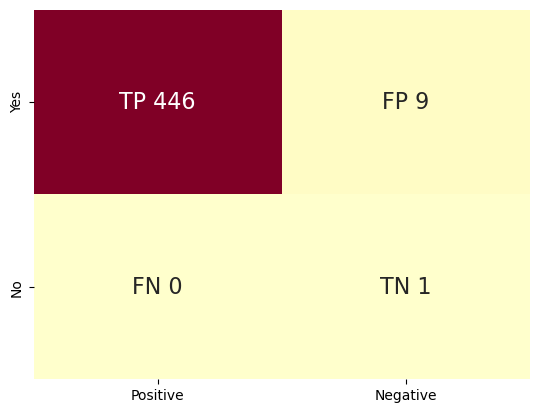

In [34]:
plot_confusion_matrix(cm)

In [35]:
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [36]:
compute_all_score(cm, t=0.5)

[0.5,
 0.9802631578947368,
 0.9802197802197802,
 1.0,
 0.9900110987791342,
 1.0,
 0.1,
 0.18181818181818182]

As we can see, the accuracy, the precision and recall positive are very high but negative labels are harder to predict, because less data is present to train the classifier onto. Hence, the precision, recall and F1 score for negative labels (i.e. Art topic) are lower.

#### A3.3 Class proportions (5 points)
1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!    
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*
2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!    
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*

Yes as mentioned before it affects the accuracy because it affects FP and FN errors which don't have the same importance, and hence bias the reported accuracy. We can fix it by adding a parameter to the SGDClassifier which is class_weight = 'balanced', which will use the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.

In [37]:
# Fix the disparity in class proportions in the classifier:
# 1. Create a new classifier with class_weight='balanced':
SGD_fixed = SGDClassifier(loss='log', alpha=1e-4, random_state=42, max_iter=5, tol=None, class_weight='balanced') #log_loss instead of loss='log
SGD_fixed.fit(X_train_binary, y_train_binary)
print("Testing accuracy:", SGD_fixed.score(X_test_binary, y_test_binary))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing accuracy: 0.9890350877192983


* Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
    **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
* Lastly, using the optimal `alpha` identified in the previous step, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

In [38]:
# Vary the regularization parameter alpha in the range[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] and find its optimal value using 5-fold cross-validation:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
clf_cv = GridSearchCV(SGD_fixed, param_grid, cv=5)
clf_cv.fit(X_train_binary, y_train_binary)
print("Best alpha:", clf_cv.best_params_)
print("Best score:", clf_cv.best_score_)
print("Testing accuracy:", clf_cv.score(X_test_binary, y_test_binary))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalen

Best alpha: {'alpha': 1e-06}
Best score: 0.9956204379562044
Testing accuracy: 0.9912280701754386


In [39]:
# optimal alpha = 1e-6, best score = 0.9956, testing accuracy = 0.9912
# We build a new model with this parameter:
final = SGDClassifier(loss='log', alpha=1e-6, random_state=42, max_iter=5, tol=None, class_weight='balanced')
final.fit(X_train_binary, y_train_binary)
print("Testing accuracy:", final.score(X_test_binary, y_test_binary))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing accuracy: 0.9912280701754386


The accuracy is now even better for the model. Let's print the confusion matrix again.

In [44]:
y_pred_final = final.predict_proba(X_test_binary)
y_pred_final = np.where(y_pred_final >= 0.5, 1, 0)

In [45]:
cm = compute_confusion_matrix(y_test_binary, y_pred_final, 0.5)

<AxesSubplot: >

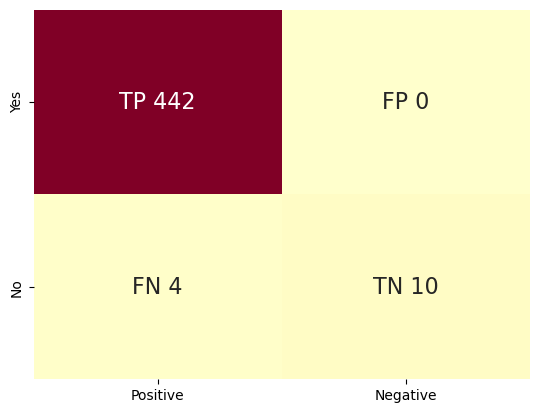

In [46]:
plot_confusion_matrix(cm)

Now, we can see that we have no false positives and way more true negatives.

### A4. Revisiting Multi-class classifier of A2.2 (4 points)

1. Print and analyze the confusion matrix for the multi-class model trained in A2.2. **/Discuss:/** What do you observe? Please elaborate!
2. **/Discuss:/** Similar to A3.3, does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!
3. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A5**.
    * Implement the fix you proposed in A4.2, and repeat the classification task performed in Step A2.2 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 2 minutes of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, obtain the accuracy and confusion matrix.
4. **/Discuss:/** Contrast the confusion matrix obtained in A4.1 with the one obtained in A4.3. Do you observe any differences? Why, or why not? Please elaborate!

In [47]:
# Print the confusion matrix for the multi-class classifier:
from sklearn.metrics import confusion_matrix
y_pred = clf_multiclass.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 59   5   2  15  17]
 [  0 304   2   2   9]
 [  0  13  88  27   1]
 [  1   3  13 182   1]
 [  0   1   0   6 323]]


In [56]:
# Topic encoding: 0 = 'Everyday_life', 1 = 'Geography', 2 = 'History', 3 = 'People', 4 = 'Science'

The two least frequent classes (2 and 0) have a much higher error than the other three more frequent classes. In fact, the error is somewhat inversely correlated with the frequency of the class. The higher the frequency the lesser the error.

In [48]:
article_df_top_5.sample(10) # Topic encoding: 0 = 'Everyday_life', 1 = 'Geography', 2 = 'History', 3 = 'People', 4 = 'Science'

,name,topic,content,topic_encoded
3022,Nouakchott,Geography,copyright nouakchott schools wikipedia selecti...,1
3938,Sunflower,Science,copyright sunflower schools wikipedia selectio...,4
1281,Earthquake,Geography,copyright earthquake schools wikipedia selecti...,1
4586,Zhang_Qian,People,copyright zhang qian schools wikipedia selecti...,3
1992,Holy_Roman_Empire,History,copyright holy roman empire schools wikipedia ...,2
1787,Great_white_shark,Science,copyright great white shark schools wikipedia ...,4
2432,Lego,Everyday_life,copyright lego schools wikipedia selection rel...,0
1898,Henry_II_of_England,People,copyright henry ii england schools wikipedia s...,3
4394,Wallis_and_Futuna,Geography,copyright wallis futuna schools wikipedia sele...,1
3703,Shanghai,Geography,copyright shanghai schools wikipedia selection...,1


We can see that TP are higher for the class having the bigger article frequency. Furthermore, the mislabelling increases for classes having lower article frequency.

In [50]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3]}
clf_multiclass = GridSearchCV(SGD_fixed, param_grid, cv=5)
clf_multiclass.fit(X_train, y_train)
print("Best alpha:", clf_multiclass.best_params_)
print("Best score:", clf_multiclass.best_score_)
print("Testing accuracy:", clf_multiclass.score(X_test, y_test))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalen

Best alpha: {'alpha': 1e-05}
Best score: 0.8870672996636209
Testing accuracy: 0.8966480446927374


In [51]:
SGD_best = SGDClassifier(loss='log', alpha=1e-5, random_state=42, max_iter=5, tol=None, class_weight='balanced')
SGD_best.fit(X_train, y_train)
print("Testing accuracy:", SGD_best.score(X_test, y_test))

c:\Users\camil\anaconda3\envs\adaexam\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Testing accuracy: 0.8966480446927374


In [52]:
y_pred = clf_multiclass.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 73   4   3   6  12]
 [  1 296   6   2  12]
 [  1   7  97  23   1]
 [  2   2  17 177   2]
 [  4   1   1   4 320]]


In [53]:
print(balanced_accuracy_score(y_test, y_pred))

0.8570573713188866


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.901     0.745     0.816        98
           1      0.955     0.934     0.944       317
           2      0.782     0.752     0.767       129
           3      0.835     0.885     0.859       200
           4      0.922     0.970     0.945       330

    accuracy                          0.897      1074
   macro avg      0.879     0.857     0.866      1074
weighted avg      0.897     0.897     0.896      1074



The results are much better now: the two low frequency classes are now better classified. This is evident from the confusion matrix, balanced accuracy score, or macro averaged f1-score.

Using 'balanced' class weights while training the model forces the loss function to give higher relative importance to training samples corresponding to the classes with lower frequency. Actually, the training samples are weighted as inverse of the class proportions.

### A5. Interpretability (4 points)
1. For each of the 5-classes considered in **A4**, obtain a list of top-10 words (sorted in descending order of their importance) based on the feature weights learned by the classifier.

2. **/Discuss:/** Qualitatively discuss the relevance of the identified words and their association with the respective class-labels. Is the classifier correct to assign them high weights? Are they truly discriminative/predictive of the respective class-labels? Justify your responses with clear and crisp reasons!

In [ ]:
# Topic encoding: 0 = 'Everyday_life', 1 = 'Geography', 2 = 'History', 3 = 'People', 4 = 'Science'
# History + Everyday_life = least frequent, order of topics: Science, People, Geography, History, Everyday_life

In [87]:
SGD_best.coef_.shape

(5, 195694)

In [88]:
SGD_best.coef_ [0][:-10] # Top 10 words for topic 0 (word coefficients for the first topic (0 = 'Everyday_life'))

array([-2.69466249e-01, -3.59378424e-01, -5.21031547e-07, ...,
        5.76767181e-02,  0.00000000e+00, -3.94289268e-08])

In [81]:
feature_names = np.array(article_df.value_counts('topic').sort_values(ascending=False).head(5).index.values)
# For each of the 5-classes considered, obtain a list of top-10 words sorted in descending order of their importance based on the feature weights learnt by the classifier:
for i in range(5):
    top10 = np.argsort(SGD_best.coef_[i])[:-10]
    X_train
    print("Class {}: {}".format(i, top10, " ".join(feature_names[i])))

Class 0: [146236 160502  98485 ... 168977  78335 188187]
Class 1: [160502 161414  24385 ... 127343 120056  67323]
Class 2: [ 12380 161924  85911 ...   3124 123463   4046]
Class 3: [ 35003 160502  18480 ...  26971 188251 186707]
Class 4: [122212  35003 184864 ...  48400  75242 132608]


In [ ]:
# CORRECTION:
#top5_coeff_indices = np.argsort(clf_multiclass.best_estimator_.named_steps['clf'].coef_)[:,-10:][:,::-1]
#print(top5_coeff_indices)
# Vectorizer needed to get the words names:
#np.array(clf_multiclass.best_estimator_.named_steps['vect'].get_feature_names())[top5_coeff_indices]

In [89]:
# Other solution:
# Topic encoding: 0 = 'Everyday_life', 1 = 'Geography', 2 = 'History', 3 = 'People', 4 = 'Science'
# History + Everyday_life = least frequent, order of topics: Science, People, Geography, History, Everyday_life
import eli5
# ou estimator = clf_multiclass.best_estimator_
eli5.show_weights(estimator = SGD_best, vec=vectorizer, top=10, feature_names=vectorizer.get_feature_names_out())

# Task B. The Wikipedia link network (30 points)

### B1. Wikipedia network: reveal your shape! (12 points)
#### B1.1 Load the Wikipedia link network (`data/links_task-B.tsv.gz`) into memory as a directed graph using `NetworkX`. (4 points)
1. Compute the following from the loaded graph object:
    * the number of nodes,
    * the number of edges, and
    * the average degree.
2. **/Discuss:/** In order to summarize the degree distribution in a single number, would you recommend using the average degree? Why, or why not? If not, what alternatives can you think of? Please elaborate!

In [5]:
# Loads the graph: G

G = nx.DiGraph()
edge_list = pd.read_csv(data_folder+"links_task-B.tsv.gz", sep="\t")

# Creates edge attributes
for _, edge in edge_list.iterrows():
    edge = dict(edge)
    G.add_edge(edge['linkSource'], edge['linkTarget'])
    
# Print number of edges
print("Number of nodes", len(G.nodes))
print("Number of edges", len(G.edges))

Number of nodes 4592
Number of edges 119882


In [6]:
edge_list

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


In [7]:
# Compute the average degree of the graph (directed):
# For a directed graph, kin = kout = L and average_degree = L/N, N = number of nodes
L = len(G.edges)
N = len(G.nodes)
average_degree = L/N
print("Average degree:", average_degree)

Average degree: 26.10670731707317


Average degree is not recommended as the degree distribution of real-world networks usually follows a powerlaw. Summarizing powerlaws with average values is not a good idea, as there is a long tail, and there are many nodes that have very high degree. Instead, median is a better choice (or harmonic mean).

#### B1.2 Using the appropriate plot type, plot the in-degree and out-degree distributions of the Wikipedia link network and analyze it. (4 points)
1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.

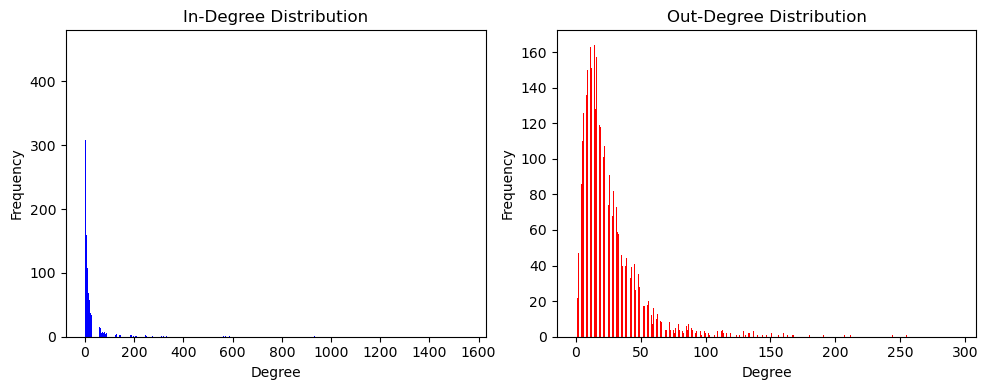

In [60]:
# Plot in-degree and out-degree distributions: 
# In-degree distribution: number of nodes with a given in-degree
degrees = {}
for node in G.nodes():
    in_degree = G.in_degree(node)
    if in_degree not in degrees:
        degrees[in_degree] = 0
    degrees[in_degree] += 1
sorted_degree = sorted(degrees.items())
deg = [k for (k,v) in sorted_degree]
cnt = [v for (k,v) in sorted_degree]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(deg, cnt, width=0.50, color='b')
#ax[0].hist(cnt, bins = 50, color='b')
ax[0].set_title("In-Degree Distribution")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Degree")
#ax[0].set_ylim(0, 100)
#ax[0].set_xticks([d+0.05 for d in deg])
#ax[0].set_xticklabels(deg)
# Out-degree distribution: number of nodes with a given out-degree
degrees = {}
for node in G.nodes():
    out_degree = G.out_degree(node)
    if out_degree not in degrees:
        degrees[out_degree] = 0
    degrees[out_degree] += 1
sorted_degree = sorted(degrees.items())
deg_out = [k for (k,v) in sorted_degree]
cnt_out = [v for (k,v) in sorted_degree]
ax[1].bar(deg_out, cnt_out, width=0.50, color='r')
#ax[1].hist(cnt_out, bins=100, color='r')
ax[1].set_title("Out-Degree Distribution")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Degree")
#ax[1].set_xticks([d+0.05 for d in deg_out])
#ax[1].set_xticklabels(deg_out)
plt.tight_layout()

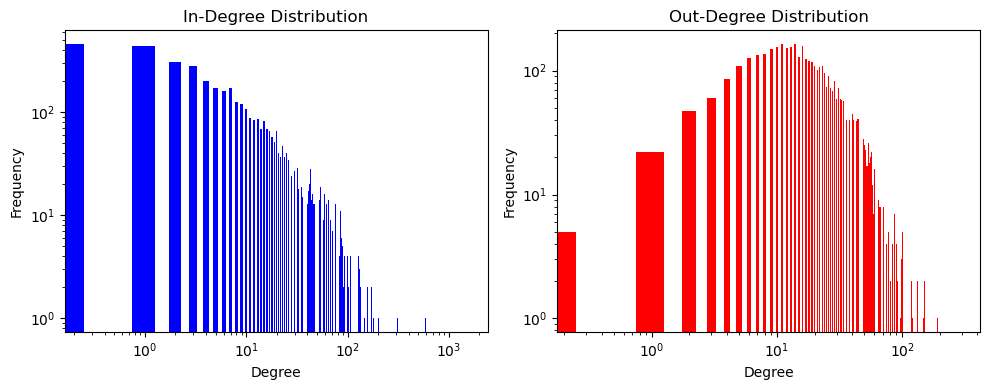

In [37]:
# Plot in-degree and out-degree distributions: 
# In-degree distribution: number of nodes with a given in-degree
degrees = {}
for node in G.nodes():
    in_degree = G.in_degree(node)
    if in_degree not in degrees:
        degrees[in_degree] = 0
    degrees[in_degree] += 1
sorted_degree = sorted(degrees.items())
deg = [k for (k,v) in sorted_degree]
cnt = [v for (k,v) in sorted_degree]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(deg, cnt, width=0.50, color='b', log=True)
ax[0].set_title("In-Degree Distribution")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Degree")
ax[0].set_xticks([d+0.05 for d in deg])
ax[0].set_xticklabels(deg)
ax[0].set_xscale("log")
# Out-degree distribution: number of nodes with a given out-degree
degrees = {}
for node in G.nodes():
    out_degree = G.out_degree(node)
    if out_degree not in degrees:
        degrees[out_degree] = 0
    degrees[out_degree] += 1
sorted_degree = sorted(degrees.items())
deg_out = [k for (k,v) in sorted_degree]
cnt_out = [v for (k,v) in sorted_degree]
ax[1].bar(deg_out, cnt_out, width=0.50, color='r', log=True)
ax[1].set_title("Out-Degree Distribution")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Degree")
ax[1].set_xticks([d+0.05 for d in deg_out])
ax[1].set_xticklabels(deg_out)
ax[1].set_xscale("log")
plt.tight_layout()

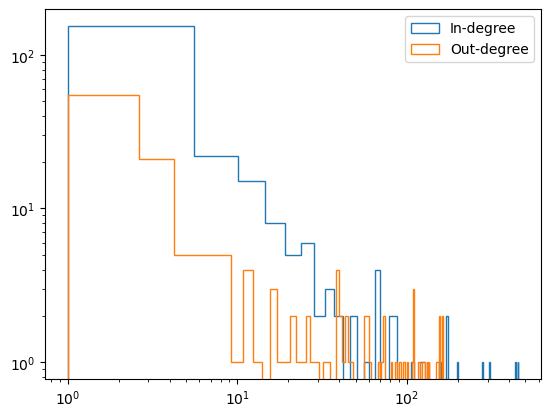

In [39]:
bar_in_degree = plt.hist(cnt,bins=100,log=True,histtype='step', label='In-degree')
bar_out_degree = plt.hist(cnt_out,bins=100,log=True,histtype='step', label='Out-degree')
plt.xscale("log")
plt.legend()

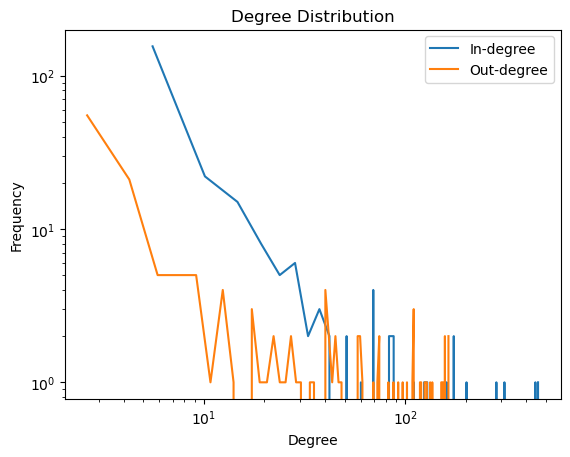

In [41]:
# Plot in-degree and out-degree distributions:
plt.loglog(bar_in_degree[1][1:],bar_in_degree[0], label='In-degree')
plt.loglog(bar_out_degree[1][1:],bar_out_degree[0], label='Out-degree')
plt.title("Degree Distribution")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend()
plt.show()

1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.
1. log-log
2. yes, power-law (line in log-log plot)

#### B1.3 Connectedness of the Wikipedia link network (4 points)

**Definition-1:** An undirected graph $G$ is said to be connected if, for every pair of vertices $(u, v)$, it contains a path that connects the two vertices.

**Definition-2:** A directed graph $G_{dir}$ is **weakly connected** (or simply connected) if the underlying undirected graph obtained by replacing all directed edges of the graph with undirected edges is a connected graph (cf. Definition-1). 

**Definition-3:** A directed graph $G_{dir}$ is **strongly connected** if, for every pair of vertices $(u, v)$, it contains a directed path from $u$ to $v$ and a directed path from $v$ to $u$.

Given these definitions, what can you say about the connectedness of the Wikipedia link network? Specifically, answer the following:
1. Is the Wikipedia link network weakly connected? If not, print the number of weakly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest weakly connected component.
2. Is the Wikipedia link network strongly connected? If not, print the number of strongly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest strongly connected component.

In [43]:
print("Weakly connected: ", nx.is_weakly_connected(G))
print(f"There are {len(list(nx.weakly_connected_components(G)))} weakly connected components")
print("Strongly connected: ", nx.is_strongly_connected(G))
print(f"There are {len(list(nx.strongly_connected_components(G)))} strongly connected components")

Weakly connected:  False
There are 2 weakly connected components
Strongly connected:  False
There are 519 strongly connected components


In [44]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(list(largest_cc))
print(len(H.nodes()), len(H.edges()), len(H.edges())/len(H.nodes()))

4589 119879 26.123120505556766


In [45]:
largest_scc = max(nx.strongly_connected_components(G), key=len)
H = G.subgraph(list(largest_scc))
print(len(H.nodes()), len(H.edges()), len(H.edges())/len(H.nodes()))

4051 111900 27.6228091829178


### B2. The interplay between human navigation behavior and Wikipedia network structure (18 points)

#### B2.1 Loading and analyzing the game data (3 points)
1. Load `data/paths_df_task-B.tsv.gz` as a pandas dataframe.
2. Some games were successfully finished (*finished=True*) while others were unsuccessful (i.e., the player gave up before reaching the target article). However, not all unsuccessful games are infeasible; the player might simply not have been good enough at the game to reach the target from the source. **/Discuss:/** Clearly state the reasons why there may be games that are *truly infeasible*.   
3. List all unsuccessful games that are *truly infeasible* and remove them from the dataframe.

In [46]:
paths = pd.read_csv(data_folder+"paths_df_task-B.tsv.gz", sep="\t", compression="gzip")
paths.head()

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec
0,6a3701d319fc3754,14th_century,African_slave_trade,True,9,3,166
1,3824310e536af032,14th_century,African_slave_trade,True,5,3,88
2,415612e93584d30e,14th_century,African_slave_trade,True,8,3,138
3,64dd5cd342e3780c,14th_century,Greece,True,4,2,37
4,015245d773376aab,14th_century,John_F._Kennedy,True,7,3,175


It's impossible to reach a target for games where there is no path existent between the source and the target in the underlying graph, indicated by the shortest_path_length of -1

In [48]:
infeasible = paths[paths["shortest_path_length"] == -1]
print(f"There are {len(infeasible)} infeasible paths")
paths = paths[paths["shortest_path_length"] != -1]

There are 8 infeasible paths


#### B2.2 Wikispeedia => Wikislowia? (9 points)
1. Compute and report the average and median path lengths for games that were successfully finished (*finished=True*). You should compute and report path length in two ways: (1) with respect to the number of clicks needed by *human players*, (2) with respect to the *minimum* number clicks an *optimal player* would need.   
   **/Discuss:/** What can you say about the navigability of the Wikipedia link network?   
   *Hint: Think about [Milgram's experiment](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_261) and relate your findings with his findings!*
2. **/Discuss:/** Suppose you want to maliciously decrease Wikipedia's navigability. You are allowed to remove certain edges in the network. What criterion would you use to decide which edges should be removed? Additionally, discuss why these edges are critical for Wikipedia's navigability. Justify your answer with clear and substantive reasoning!   
   _Hint: Navigability of a network depends on the existence of short paths in the network._
3. **/Discuss:/** In continuation to B2.2.2, assume you are given a budget of $k<<n$ edges to be removed. Design the algorithm that you would employ, provide its pseudocode (as a list of steps), and justify your algorithm design choice.   
   *Note: You don't have to describe the steps for computing the criterion you identified in Step B.2.2. Instead, using the identified criterion as a blackbox, you have to provide the steps required to remove $k>1$ edges.*

In [50]:
# Compute the average and median path length for games that were successfully finished:
paths_new = paths[paths["finished"] == True]
# method 1:
print(f"The average path length is {paths_new['human_path_length'].mean()}")
print(f"The median path length is {paths_new['human_path_length'].median()}")
# method 2:
print(f"The average path length is {paths_new['shortest_path_length'].mean()}")
print(f"The median path length is {paths_new['shortest_path_length'].median()}")

The average path length is 6.757493081810033
The median path length is 6.0
The average path length is 2.845500253342168
The median path length is 3.0


**Answering B2.2**
1. The average and median path length based on human navigation in the completed games is 6.75 and 6, respectively. Similar to the 6-degrees of separation results in Milgram's experiment! Also, avg and median shortest path lengths are 2.85 and 3, respectively, which shows that short paths do exist in the network, and the former result shows that they are discoverable by humans without knowledge of the overall network structure.
2. Find the edge with the **highest edge betweenness centrality value**. Removing such an edge would impact a lot of shortest paths, as the **highest fraction of shortest paths pass through this edge**.
3. Pseudocode: (Iterative greedy)
   Step-1: Find the edge with the highest betweenness centrality value.
   Step-2: Remove the edge.
   Step-3: Repeat Steps 1 and 2, until k edges have been removed.
   Note: Removing k-edges based on their betweenness centrality in one-go is not the best way to proceed, iterative greedy is better!

#### B2.3 Relationship between network structure and game completion (6 points)
1. Enrich the dataframe with the eigenvector centrality and in-degree of the target article for each game path.
2. Using plots of appropriate type, plot the in-degree distribution of the target articles of game paths. What is the appropriate scale of the axes? Additionally, summarize the in-degree distribution of the target articles in a single number using a suitable metric. Justify your choice of the metric.
3. Using plots of appropriate type, analyze the differences in in-degree and eigenvector centrality of finished and unfinished games.   
   **/Discuss:/** What do you observe? Clearly discuss your observations!

In [ ]:
# enrich dataframe with eigenvector centrality and in-degree of the target article for each game path:
paths["target_eigenvector_centrality"] = paths["target"].apply(lambda x: nx.eigenvector_centrality(G, weight="weight")[x])
paths["target_in_degree"] = paths["target"].apply(lambda x: G.in_degree(x))
paths.head()

# Task C. Putting on the causality hat (30 points)

### C1. Are articles with high in-degree easier to find? A naive analysis (6 points)

Recall that in each Wikispeedia game, a player is **randomly** assigned a source article and a target article. In task **C**, we are interested in measuring the effect of the target article's in-degree on the player's chances of successfully finishing the game.

1. Load `data/paths_df_task-C.tsv.gz` as a pandas dataframe.
2. Consider target articles with fewer than 20 incoming links to have a *low in-degree* and articles with at least 20 to have a *high in-degree*.
3. Calculate the fraction of games with a high-in-degree target that was finished, and the fraction of games with a low-in-degree target that was finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
4. Repeat the same analysis for the game duration, for finished games only.
5. Quantify and discuss your findings from Steps C1.3 and C1.4.

In [15]:
'''your answer/code here''';

### C2. Modeling the study setup with a causal diagram (9 points)

**C2.1** We are interested in the effect of target in-degree (**deg(T)**) on the binary outcome **(O)** that captures whether the game was successfully finished or not. In the previously conducted naive analysis, we did not take into account the shortest path length **(L)**, which is the minimum number of clicks necessary in order to reach the target article from the source article **(S)**. Target and source articles are randomly assigned, independently from each other. The assigned source article S and deg(T) affect the shortest path length L. The source article affects the outcome through the shortest path length, and also directly, as some sources might be more central in the network.   
Choose a causal diagram **(A, B, C, D, E, or F)** that corresponds to the described relationships between the following 4 variables. Additionally, justify your choice and explain your reasoning. **(4 points)**
- **deg(T):** target in-degree,
- **L:** shortest path length between source and target,
- **S:** name of source article,
- **O:** outcome, i.e., the binary indicator that says whether the game was successfully finished.

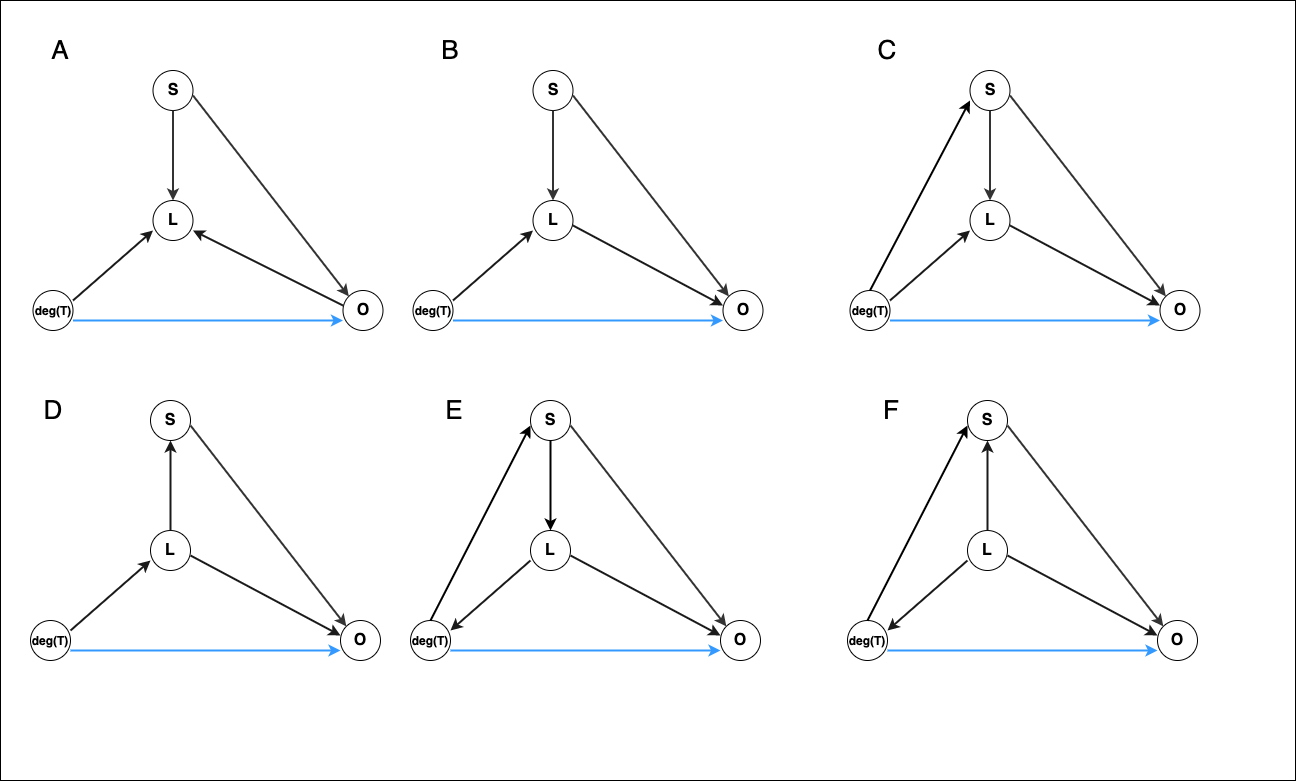

In [16]:
Image(filename="img/diagram.png") 

In [17]:
'''your answer here''';

**C2.2** **/Discuss:/** What is potentially misleading about the naive analysis done in task **C1**? In what conceivable ways could the conclusions about the impact of target in-degree **deg(T)** on the outcome **O** be wrong?
Could the findings go in the opposite direction of a true direct causal effect? Justify your answer. **(5 points)**

In [18]:
'''your answer here''';

### C3. A more controlled analysis: matching on source article and shortest path length (15 points)

Let's now understand how the estimated effect of the target in-degree would differ if we controlled for both the source article and the shortest path length between source and target. Construct a set of matched pairs of games. In a matched pair, the two games differ in target in-degree (one has a high in-degree, and the other has a low in-degree), but the source article and the shortest path length are exactly the same. Note that your output must be a 1-to-1 matching.

1. Perform exact matching on source article and shortest path length. This means that two candidate games can be matched only if the source article and the shortest path length are exactly the same. Additionally, report the number of matched pairs of games. **(7 points)**   
   **Important heads-up**: *Depending on the configuration of your computer, computing the exact matching could take up to 3 minutes of compute time.*
2. Among the matched pairs of games, calculate the fraction of games with a high-in-degree target that was successfully finished, and the fraction of games with a low-in-degree target that was successfully finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.) **(3 points)**
3. **/Discuss:/** What do you observe? Are the conclusions different from the conclusions reached in C1? If yes, speculate as to why that is the case. How is the estimation in task C1 different from the estimation in task C3? **(4 points)**
4. **/Discuss:/** Based on your findings, how should Wikipedia be modified in order to increase the fraction of finished Wikispeedia games? **(1 points)**

*Hint: How you construct the set of matched pairs is up to you. One way can be to build an unweighted bipartite graph where games with targets with a high in-degree are on one side (the "treated class"), and games with targets with a low in-degree are on the other side (the "control class"). The edge between two matching candidate games is created only if there is an exact match on the source article and the shortest path length. Based on this bipartite graph, you can then find the **optimal** matching. However, note that this is neither the required nor the only way.*

In [19]:
'''your answer/code here''';